In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

random.seed(98)

In [2]:
dices = {
    'red': [2,2,2,2,6,6],
    'blue': [3] * 6,
    'black': [0,0,4,4,4,4],
    'green': [1,1,1,5,5,5]   
}

# we create a dictionary for the ladders and chutes.  The key is the start state of the chute/ladder
# and the value is the ending state.
ladders = {1:38,4:14,9:31,21:42,28:84,36:44,51:67,71:91,80:100}
chutes = {16:6,48:26,49:11,56:53,62:19,64:60,87:24,93:73,95:75,98:78}

In [3]:
def nextState (state, roll):
    '''
    This function transitions from the current state and current dice roll to the next state.
    INPUTS:
        state is the current state you are in (0 to 100)
        roll is the number showing on the dice (1 to 6)
    RETURN VALUE:
    this function returns the next state integer
    '''
    next_state = state + roll
    if next_state > 100:
        next_state = 100
    # now check for ladders
    if next_state in ladders:
        next_state = ladders[next_state]
    # now check for chutes
    if next_state in chutes:
        next_state = chutes[next_state]
        
    return next_state

In [4]:
def create_state_mat(policy):
    """
    Build the state matrix when following a specific policy
    """
    state_mat = [[0.0] * 101 for _ in range(101)]
    state_mat[100][100] = 1.0
    
    for state in range(100):
        dice = policy[state]
        rolls_cnt = len(dices[dice])
        rolls_freq = Counter(dices[dice])

        for roll, freq in rolls_freq.items():
            next_state = nextState(state, roll)
            state_mat[state][next_state] += -(float(freq) / float(rolls_cnt))
    
    for state in range(100):
        state_mat[state][state] += 1.0
    
    return state_mat

def evaluate_policy(policy):
    """
    Evaluate a specific policy.
    Return the expected number of steps when starting from state 0 following this policy.
    """
    state_mat = create_state_mat(policy)
    
    # Singular matrix
    if np.linalg.det(state_mat) == 0:
        return float('inf')
    
    # Ax = b
    _b = [1.0] * 101
    _b[100] = 0.0
    
    A = np.array(state_mat)
    b = np.array(_b)
    x = np.linalg.solve(A, b)
    
    # Expected number of steps when starting from state 0
    return x[0]

def improve_policy(policy, best_steps):    
    """
    Improve the policy in-place.
    Return the best expected number of steps.
    """
    for state in range(99, -1, -1):
        for dice, _ in dices.items():
            old_dice = policy[state]
            policy[state] = dice
            exp_steps = evaluate_policy(policy)
            
            # Our current policy is better, so no need to update
            if best_steps <= exp_steps:
                policy[state] = old_dice
            else:
                best_steps = exp_steps
                
    return best_steps

In [5]:
def find_policy(policy):
    """
    Search for the best policy starting from an initial policy.
    Return:
        - best policy.
        - best expected steps from the initial policy.
        - number of iterations until convergence
    """
    best_steps = evaluate_policy(policy)
    iterations = 0
    
    while True:
        iterations += 1
        new_steps = improve_policy(policy, best_steps)
        if new_steps != float('inf') and np.isclose(best_steps, new_steps):
            break
        best_steps = new_steps

    return policy, best_steps, iterations

def print_policy(policy, best_steps, iterations):
    print(f'1. Best expected number of steps = {best_steps}')
#     print()
    print(f'2. Policy = {policy}')
#     print()
    print(f'3. Number of iterations until convergence = {iterations}')

In [6]:
for dice, _ in dices.items():
    policy, best_steps, iterations = find_policy([dice] * 101)
    print(f'Best policy starting from a policy with all {dice}')
    print()
    print_policy(policy, best_steps, iterations)
    print()

Best policy starting from a policy with all red

1. Best expected number of steps = 11.617283950617276
2. Policy = ['black', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'black', 'red', 'red', 'red', 'black', 'red', 'red', 'red', 'black', 'red', 'black', 'red', 'red', 'red', 'black', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'black', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'black', 'red', 'red', 'red', 'green', 'red', 'red', 'red', 'blue', 'red', 'red', 'red', 'green', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'red', 'green', 'black', 'blue', 'red', 'green', 'red', 'green', 'red', 'red', 'red', 'blue', 'red', 'red', 'red', 'green', 'red', 'blue', 'blue', 'red', 'red', 'red', 'black', 'blue', 'red', 'red', 'red']
3. Number of iterations until convergence = 3

Best policy starting from a policy with all blue

1. Best expected number of steps = 12.4

In [7]:
opt_policy, best_steps, iterations = find_policy(['green'] * 101)

In [12]:
def roll(dice_color):
    '''
    This function randomly rolls one of the four effron dice.  
    INPUT:
    dice_color should be among "red","blue","black", or "green"
    OUTPUT:
    an integer randomly selected from one of the dice
    '''
    
    if dice_color == 'red':
        return random.choice([2,2,2,2,6,6])
    if dice_color == 'blue':
        return 3
    if dice_color == 'black':
        return random.choice([0,0,4,4,4,4])
    if dice_color == 'green':
        return random.choice([1,1,1,5,5,5])
    # for invalid input
    return None

def simulate(policy):
    state = 0
    steps = 0
    
    while state != 100 and steps < 100:
        dice = policy[state]
        roll_res = roll(dice)
        state = nextState(state, roll_res)
        steps += 1
    
    return steps

In [13]:
print(simulate(opt_policy))

11


In [14]:
def assess(policy, trials):
    '''
    Assess the value of the current policy by completing #trials using the specified policy.
    '''
    steps = []
    for _ in range(trials):
        steps.append(simulate(policy))
    return steps

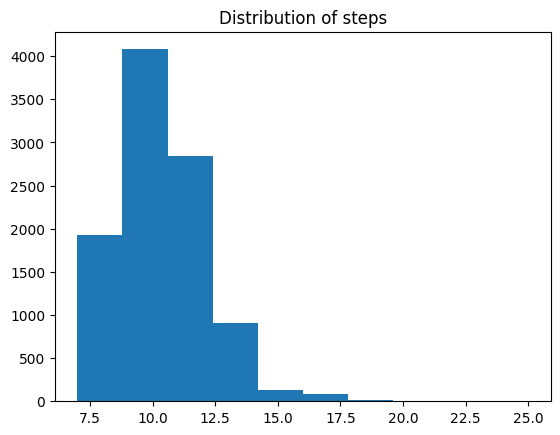

In [15]:
trials_res = assess(opt_policy, 10000)
plt.hist(trials_res)
plt.title('Distribution of steps')
plt.show()